### Load data

In [2]:
import pickle
with open('splitData.pickle', 'rb') as f:
    texts_train = pickle.load(f)
    texts_val = pickle.load(f)
    texts_test = pickle.load(f)
    labels_train = pickle.load(f)
    labels_val = pickle.load(f)
    labels_test = pickle.load(f)

all_texts  = texts_train  + texts_val  + texts_test
all_labels = labels_train + labels_val + labels_test
# check the ratio of each dataset
total = len(texts_train) + len(texts_val) + len(texts_test)
len(texts_train)/total, len(texts_val)/total, len(texts_test)/total

(0.5997757847533632, 0.20011210762331838, 0.20011210762331838)

# Q2-Clustering

### Step 0: Vectorise text

## NOTE: lyrics are not necessarily limited to English

In [7]:
import spacy

nlp = spacy.load('en_core_web_sm')
# nlp = spacy.load("xx_ent_wiki_sm")

def text_pipeline_spacy(text):
    tokens = []
    doc = nlp(text)
    for t in doc:
        if not t.is_stop and not t.is_punct and not t.is_space:
            tokens.append(t.lemma_.lower())
    return tokens

# Example usage:
text_pipeline_spacy("Of all the things I miss, I miss my mind the most.")

['thing', 'miss', 'miss', 'mind']

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(tokenizer=text_pipeline_spacy)

texts_vector = vectorizer.fit_transform(all_texts)
texts_vector.shape

(1784, 19687)

## Conducting Kmeans

In [22]:
import numpy as np
np.random.seed(42)
def kmeans(k, matrix, max_iter=300):
    num_data, dim_feature = matrix.shape

    # Step1: pick k random centroids
    #### centroids = np.random.random([k,22406])  # Random Partition --- does not work well
    #Use Forgy partition to make sure at least one point is allocated to one point
    centroids = matrix[np.random.randint(0,num_data,k)]


    # new centroids to be calculated
    new_centroids = np.zeros((k,dim_feature))

    # labels(=index of centroids) assigned to data
    labels = np.zeros(num_data)

    # iterate until convergence or max_iteration
    for itr in range(max_iter):
        
        # iterate through all data
        for i in range(num_data):
            # matrix is a sparse vector, so make it dense array
            ith_vec = np.squeeze(np.asarray(matrix[i].todense()))

            #Step2: Assign each vector to its closest centroid
            dists = np.sum(np.square(centroids - ith_vec), axis=1)
            labels[i] = np.argmin(dists)

        #Step3:Recalculate the centroids
        for j in range(k):
            new_centroids[j] = matrix[labels==j].mean(axis=0)

        # If step 2 and 3 converges, exit for-loop         
        if np.all(new_centroids == centroids):
            print("converged")
            break;
        centroids = new_centroids

    return labels, new_centroids


clustered_labels, centroids = kmeans(5,texts_vector)
from collections import Counter
clustered_labels = [str(int(l)) for l in clustered_labels]
Counter(clustered_labels)

converged


Counter({'3': 548, '2': 307, '0': 270, '4': 409, '1': 250})

### For answering questions

In [23]:
# question a)
for i in range(5):
    print(f"------top 5 tokens in centroid {i}-----")
    indices = np.argsort(centroids[i])[:15] # indices of most prominent tokens
    for key,val in vectorizer.vocabulary_.items():
        if val in indices:
            print(f'{key}',end=",")
    print("\n")

# tokenizerを工夫したほうがよいかも

------top 5 tokens in centroid 0-----
"embe,mechanic,me?you,me97embed,mean?40embed,me?8embe,meanie,me6embed,measurin,me67embe,me?embed,me54embed,me99embe,measurement,me8embe,

------top 5 tokens in centroid 1-----
oncoming,one'll,"embe,online,onion,ono,onlyfan,onde,ondas,one)51embed,one44embed,one1embed,onembe,one',one.march,

------top 5 tokens in centroid 2-----
on)181embe,"embe,olvidó,olvidaré,ominous,olúwa,omar,olvidé,olympics,olympic,on2embed,on"*s"same,omelette,omnipotent,olvide,

------top 5 tokens in centroid 3-----
"embe,ni,nickle,nicki,nibble,nicotine,niegas,nicky,niah,niche,niall,niagara,ngizogobisa,nibabuzile,niap,

------top 5 tokens in centroid 4-----
likea,ni,new-,newspaper,newly,newsweek,niah,news!3embe,newborn,nfing,newsstand,ngizogobisa,ngami,ngozi,newman,



In [ ]:
# cm=confusion_matrix(clustered_labels, all_labels)
# ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['not clinical trial','clinical trial']).plot()

# confusion matrixの完成形がわからん

<AxesSubplot:xlabel='k-means labels', ylabel='target labels'>

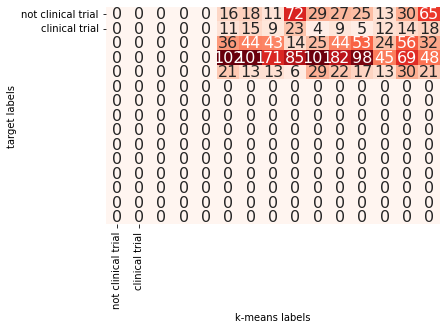

In [17]:
# question c) construct a confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sn

def plotConfusionMatrix(labels_val, labels_predicted):
  cm = confusion_matrix(labels_val, labels_predicted)
  colour_map = sn.color_palette("Reds", as_cmap=True)
  labels = ['not clinical trial', 'clinical trial']
  plot = sn.heatmap(cm, 
                    annot=True, # Put the numbers in
                    annot_kws={"size": 16}, # Make the numbers bigger
                    fmt='g', # Stop scientific notation
                    cmap = colour_map, # Choose the colour palette
                    cbar = False, # Don't include the colour bar
                    xticklabels=labels, # Put in the X and Y labels
                    yticklabels=labels)
  plot.set(xlabel='k-means labels', ylabel='target labels')
  return plot

plotConfusionMatrix(clustered_labels, all_labels)

In [25]:
from sklearn.cluster import KMeans
from collections import Counter
kmeans = KMeans(n_clusters=5, random_state=10).fit_predict(texts_vector)
Counter(kmeans)

Counter({4: 1092, 2: 199, 1: 86, 0: 308, 3: 99})

# Q3-Comparing Classifiers

In [26]:

# Show classifier performance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def showPerformance(labels_true, labels_predicted):
    print(f'accuracy ={accuracy_score(labels_true, labels_predicted):.3f}')
    print(f'precision={precision_score(labels_true, labels_predicted, average="macro"):.3f}')
    print(f'recall   ={recall_score(labels_true, labels_predicted, average="macro"):.3f}') 
    print(f'f1       ={f1_score(labels_true, labels_predicted, average="macro"):.3f}')
    return ;


### Dummy Classifier with strategy="most_frequent"

In [27]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(texts_train,labels_train)
labels_predicted = dummy_clf.predict(texts_val)

print(dummy_clf.score(texts_val, labels_val))
showPerformance(labels_val, labels_predicted)

0.08403361344537816
accuracy =0.084
precision=0.008
recall   =0.100
f1       =0.016


/home/denjo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Dummy Classifier with strategy="most_frequent"

In [28]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(texts_train,labels_train)
labels_predicted = dummy_clf.predict(texts_val)

# print(dummy_clf.score(texts_val, labels_val))
showPerformance(labels_val, labels_predicted)

accuracy =0.070
precision=0.066
recall   =0.067
f1       =0.065


### LogisticRegression with one-hot vectorization

In [30]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
vectorizer = CountVectorizer(tokenizer=text_pipeline_spacy)

vect_texts_train = vectorizer.fit_transform(texts_train)
vect_texts_train[vect_texts_train != 0] = 1 # convert non-zero counting into 1

vect_texts_val = vectorizer.transform(texts_val)
vect_texts_val[vect_texts_val != 0] = 1

# Logistic Regression
clf = LogisticRegression(random_state=42,max_iter=1000).fit(vect_texts_train, labels_train)
labels_predicted = clf.predict(vect_texts_val)


showPerformance(labels_val, labels_predicted)

accuracy =0.563
precision=0.565
recall   =0.567
f1       =0.556


### LogisticRegression with TF-IDF vectorization

In [31]:
vectorizer = TfidfVectorizer(tokenizer=text_pipeline_spacy)
vect_texts_train = vectorizer.fit_transform(texts_train)
vect_texts_val = vectorizer.transform(texts_val)

# Logistic Regression
clf = LogisticRegression(random_state=42).fit(vect_texts_train, labels_train)
labels_predicted = clf.predict(vect_texts_val)


showPerformance(labels_val, labels_predicted)


accuracy =0.451
precision=0.424
recall   =0.444
f1       =0.413


/home/denjo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### SVC Classifier with One-hot vectorization

In [32]:
# making one-hot vectors
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(tokenizer=text_pipeline_spacy)
vect_texts_train = vectorizer.fit_transform(texts_train)
vect_texts_train[vect_texts_train != 0] = 1 # convert non-zero counting into 1

vect_texts_val = vectorizer.transform(texts_val)
vect_texts_val[vect_texts_val != 0] = 1

from sklearn.svm import SVC
clf = SVC(random_state=42).fit(vect_texts_train, labels_train)
labels_predicted = clf.predict(vect_texts_val)


showPerformance(labels_val, labels_predicted)

accuracy =0.518
precision=0.498
recall   =0.514
f1       =0.481


/home/denjo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Q4-Parameter Tuning

#### choose C value

In [34]:
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid
param_C = {'C':np.logspace(-3,5,9,base=10.0)}

max_f1 = 0
best_param = {}
for params in tqdm(ParameterGrid(param_C)):
  # vectorize training set and validation set
  vectorizer = TfidfVectorizer()
  vect_texts_train = vectorizer.fit_transform(texts_train)
  vect_texts_val = vectorizer.transform(texts_val)

  # logistic regression
  clf = LogisticRegression(random_state=42,C=params['C'],max_iter=1000).fit(vect_texts_train, labels_train)
  labels_predicted = clf.predict(vect_texts_val)

  cur_f1 = f1_score(labels_val, labels_predicted,average="macro")
  if(cur_f1 > max_f1):
    max_f1 = cur_f1
    best_param = params

print(f'{best_param=}')
print(f'{max_f1:.3f}')



100%|██████████| 9/9 [01:32<00:00, 10.31s/it]

best_param={'C': 100.0}
0.504


#### choose vectorizer

In [36]:
param_vec = {'max_features':[None, 5, 50, 500, 5000, 50000], 'sublinear_tf':[True,False]}

max_f1 = 0
best_param = {}
for params in tqdm(ParameterGrid(param_vec)):
  # vectorize training set and validation set
  vectorizer = TfidfVectorizer(tokenizer=text_pipeline_spacy, max_features=params["max_features"], sublinear_tf=params["sublinear_tf"])
  vect_texts_train = vectorizer.fit_transform(texts_train)
  vect_texts_val = vectorizer.transform(texts_val)

  # logistic regression
  clf = LogisticRegression(random_state=42,C=100,max_iter=1000).fit(vect_texts_train, labels_train)
  labels_predicted = clf.predict(vect_texts_val)

  cur_f1 = f1_score(labels_val, labels_predicted,average="macro")
  if(cur_f1 > max_f1):
    max_f1 = cur_f1
    best_param = params

print(f'{best_param=}')
print(f'{max_f1:.3f}')


100%|██████████| 12/12 [22:03<00:00, 110.32s/it]

best_param={'max_features': 5000, 'sublinear_tf': True}
0.562


In [37]:

param_vec = {'max_features':[None, 5, 50, 500, 5000, 50000], 'sublinear_tf':[True,False]}

max_f1 = 0
best_param = {}
for params in tqdm(ParameterGrid(param_vec)):
  # vectorize training set and validation set
  vectorizer = TfidfVectorizer(max_features=params["max_features"], sublinear_tf=params["sublinear_tf"])
  vect_texts_train = vectorizer.fit_transform(texts_train)
  vect_texts_val = vectorizer.transform(texts_val)

  # logistic regression
  clf = LogisticRegression(random_state=42,C=100,max_iter=1000).fit(vect_texts_train, labels_train)
  labels_predicted = clf.predict(vect_texts_val)

  cur_f1 = f1_score(labels_val, labels_predicted,average="macro")
  if(cur_f1 > max_f1):
    max_f1 = cur_f1
    best_param = params

print(f'{best_param=}')
print(f'{max_f1:.3f}')

100%|██████████| 12/12 [01:08<00:00,  5.69s/it]

best_param={'max_features': None, 'sublinear_tf': True}
0.553


# Q5-Context vectors using BERT

In [5]:
from transformers import AutoTokenizer

import torch
# tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

ModuleNotFoundError: No module named 'torch'

In [3]:
tokenizer.tokenize("I walked through Kelvingrove.")

['i', 'walked', 'through', 'kelvin', '##grove', '.']

In [39]:
import numpy as np
def softmax(z):
    assert len(z.shape) == 2


    s = np.max(z, axis=1)
    s = s[:, np.newaxis] # necessary step to do broadcasting
    e_x = np.exp(z - s)
    div = np.sum(e_x, axis=1)
    div = div[:, np.newaxis] # dito
    return e_x / div


x1 = np.array([[12.1,91.1,89.3, 44.1]])
softmax(x1)


array([[4.21015997e-35, 8.58148935e-01, 1.41851065e-01, 3.32446694e-21]])